In [29]:
import tensorflow as tf
from tensorflow import keras
from skimage import io
from skimage.io import imread_collection
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
import shutil

## Fetch Data (Images)
We begin by fetching a dataset of 10,000 images from [thispersondoesnotexistcom](https://www.thispersondoesnotexist.com). We do so by requesting from the endpoint `thispersondoesnotexist.com/images` 10,000 (k) times.

In [30]:
image_path = "./images"

In [31]:
def save_image(image, count):
        with open(f'{image_path}/img_{count}.png', 'wb') as f:
            f.write(image)

In [32]:
def fetch_images(k: int, folder_name: str):
    """ 
    Fetch images from thispersondoesnotexist.com
    
    :param k: number of images to fetch
    :param folder_name: name of folder to save images to
    """
    if k < 1:
        return 0
    
    # Locals
    count = 0
    endpoint = 'image'
    url = f'https://thispersondoesnotexist.com/{endpoint}'
    while count < k:
        image = requests.get(url).content
        save_image(image)
        count += 1
        
        # A time.sleep(x) is recommended to avoid latency errors

We can now call this function and store the images locally

```python
fetch_images(k=8894, folder_name='images')
```

## Validating image
We should validate wether the image exists

In [33]:
def read_image(folder_name:str, idx:int):
    return io.imread(f'{folder_name}/img_{idx}.png')

In [34]:
def image_exists(folder_name:str) -> bool:
    """ 
    Check whether an image exists in folder_name
    
    :param folder_name: folder in which dataset images are located
    """
    try:
        # Default image 0
        image = read_image(image_path, 0)
        return True
    except:
        print(f'Image "img_0.png" in {folder_name} not found')
        return False

## Showing a batch
We can see a random batch of images from the dataset

In [35]:
def show_batch(batch):
    images = np.random.randint(low=0, high=len(batch), size=16) # get random indices
    fig = plt.figure(figsize= (4, 4)) 
    fig, axs = plt.subplots(4,4, sharex=True, sharey=True)
    cnt = 0 
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(batch[images[cnt]]) # get image from batch at index 'i'
            cnt += 1
    plt.show()

### Image Attributes

In [36]:
def img_attr(batch):
    print(f'Images are {batch[0].shape[0]} by {batch[0].shape[1]} with {batch[0].shape[2]} channels')

Retreive all images from dataset

In [37]:
def read_collection(folder_name:str):
    return imread_collection(f'{folder_name}/*.png')

In [71]:
collection = read_collection(image_path)

In [72]:
len(collection)

8895

<Figure size 288x288 with 0 Axes>

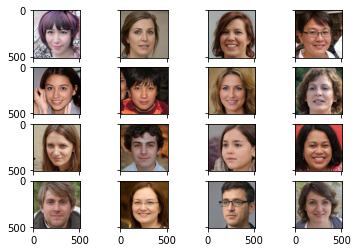

In [73]:
show_batch(collection)

In [74]:
collection[0].shape

(512, 512, 3)

In [75]:
img_attr(collection)

Images are 512 by 512 with 3 channels


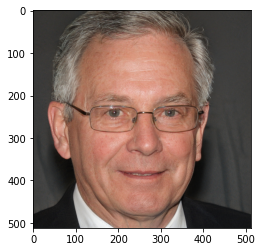

In [76]:
plt.imshow(collection[0])

### Resizing Images
As we can see, all images fetched are $1024 \times 1024 \times 3$, it is necessary we resize these into smaller dimensions to efficiently approach this DCGAN.

We import `CV2` to resize the images in `./images`

In [77]:
import cv2

We now resize every image in the `collection` and update them with given the new dimensions. All images in `collection` are named as their appropriate index in this list

In [78]:
def resize_image(image, size):
    resized_image = cv2.resize(image, dsize=size, interpolation=cv2.INTER_CUBIC)
    return Image.fromarray(resized_image)

for i in range(len(collection)):
    new_image = resize_image(collection[i], (512, 512))
    new_image.save(f'{image_path}/img_{i}.png')

### Neural Network - 1.0
We begin by definning attributes. All images in the dataset are from [thispersondoesnotexistcom](https://www.thispersondoesnotexist.com), therefore all images are $1024 \times 1024$ with $3$ channels

In [79]:
rows = collection[0].shape[0]
cols = collection[0].shape[1]
channels = collection[0].shape[2]

In [80]:
image_shape = (rows, cols, channels)

`z_dim` represents the dimenions of the noise vector to be inputed into the generator

We first import libraries to be used

In [81]:
from keras.layers import Dense, Flatten, Reshape, Conv2DTranspose, UpSampling2D, Activation, Conv2D, BatchNormalization, UpSampling2D
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam
import time

In [82]:
z_dim = 128 # 512 is a good default

We implement the schematics for $G(z)$ to generate $1024 \times 1024$ images from [Marchesi, Marco. (2017). Megapixel Size Image Creation using Generative Adversarial Networks.](https://www.researchgate.net/publication/317300265_Megapixel_Size_Image_Creation_using_Generative_Adversarial_Networks), [Karras, Aila. (2018). Progressive Growing of GANs for Improved Quality Stability, and Variation.](https://arxiv.org/pdf/1710.10196.pdf)

#### Generator 

In [83]:
from keras.utils.vis_utils import plot_model

In [84]:
def model_to_png(model, file_name:str):
    plot_model(model, to_file=f'{file_name}.png', show_shapes=True)

We can test our generator's functionality

In [85]:
def create_generator(z):
    model = Sequential()

    # Input Latent vector
    model.add(Dense(1*1*128, input_dim=z))
    model.add(Reshape((1, 1, 128)))
    
    # Conv
    model.add(Conv2DTranspose(128, kernel_size=4, padding='valid'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    # double processing: model.add(Conv2DTranspose(128, kernel_size=3, padding='same'))
    
    # Conv
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(32, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(16, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(16, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Conv2DTranspose(3, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Activation('tanh'))
    return model

In [86]:
def test_gen(z):
    gen = create_generator(z)
    noise = tf.random.normal([1, 128],)
    img = gen(noise, training=False)
    img = tf.reshape(img, shape=(img.shape[1], img.shape[2], img.shape[3]))
    '''flat = tf.reshape(img, [-1]).numpy()
    print(flat)
    plt.hist(flat, range=(np.amin(flat),np.amax(flat)))'''
    plt.imshow(img)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


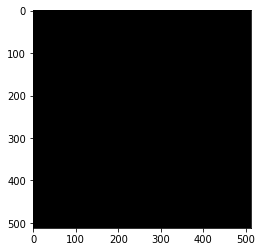

In [87]:
test_gen(z=z_dim)

#### Discriminator

In [88]:
def create_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(3, kernel_size=1, padding='same', input_shape=img_shape))
    model.add(Conv2D(3, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(16, kernel_size=3, strides=2, padding='same', input_shape=img_shape))
    
    # Conv 2.0
    model.add(Conv2D(16, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(32, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 3.0
    model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(64, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 3.0
    model.add(Conv2D(64, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(128, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 4.0
    model.add(Conv2D(128, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(128, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    model.add(Conv2D(128, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 5.0
    model.add(Conv2D(128, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(128, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    model.add(Conv2D(128, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 6.0
    model.add(Conv2D(128, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(128, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
              
    # Finalized
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [89]:
discriminator = create_discriminator(img_shape=image_shape)

#### Set up (S) - 1.1 Create
We begin by initializing the discriminator and generator

In [90]:
generator = create_generator(z=z_dim)
discriminator = create_discriminator(img_shape=image_shape)

#### S - 1.2 Compile 
We know compile both models. <br>
NOTE: _Implement OS exisitng model loading_

##### Generator Compile

In [91]:
generator.compile(loss='binary_crossentropy', 
                  optimizer=Adam())

##### Discriminator Compile

In [92]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

#### S - 1.3 Disable Discriminator Training

In [93]:
discriminator.trainable = False

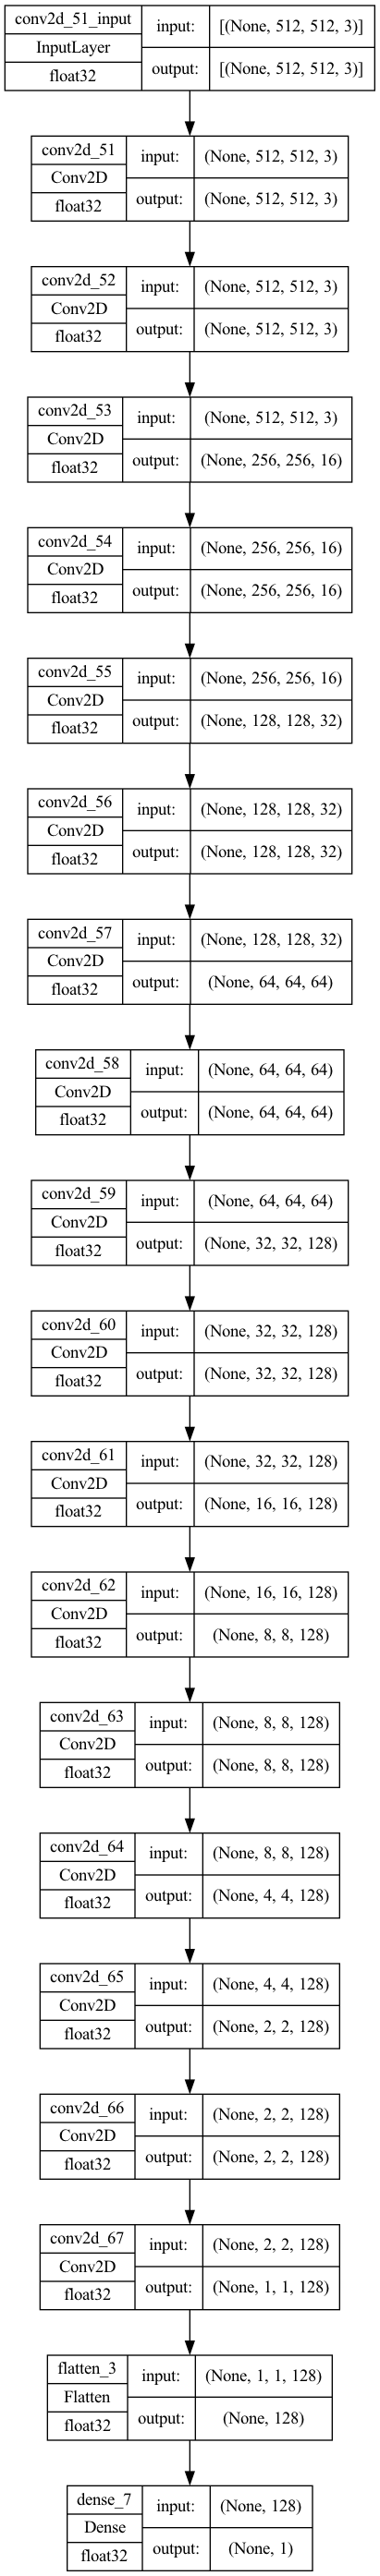

In [94]:
plot_model(discriminator, to_file='discriminator.png', show_shapes=True, show_dtype=True, show_layer_names=True)

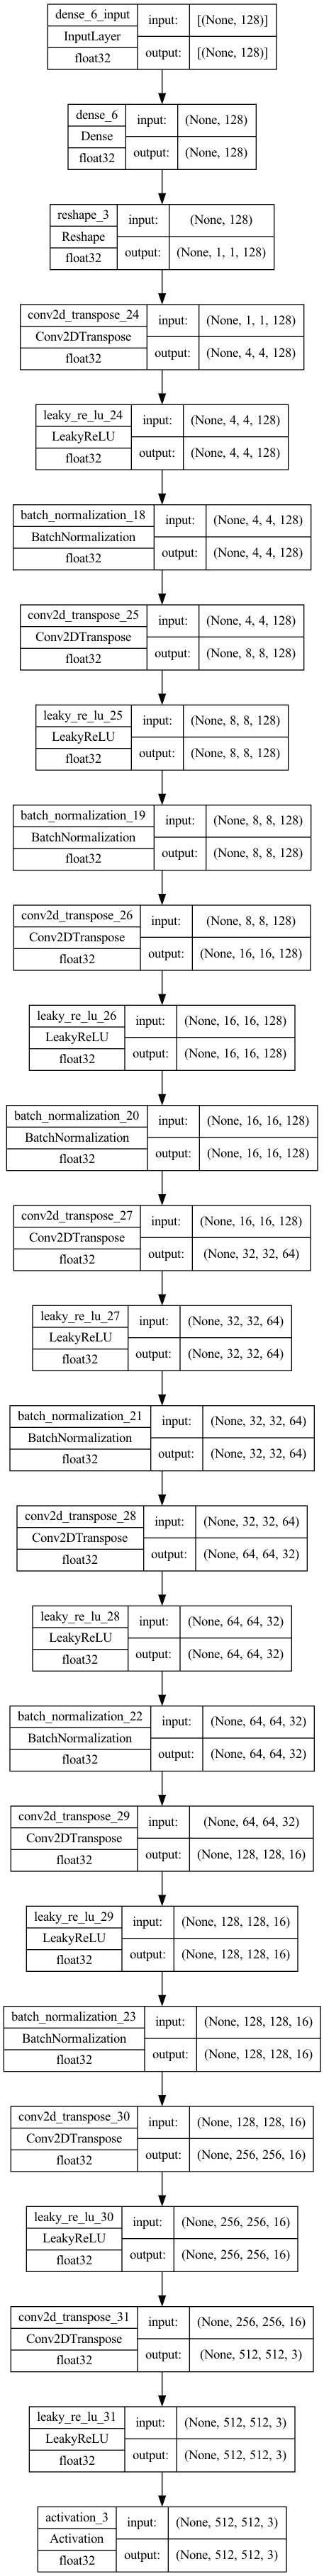

In [95]:
plot_model(generator, to_file='generator.png', show_shapes=True, show_dtype=True, show_layer_names=True)

In [96]:
def GAN(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    return model

In [97]:
gan = GAN(generator, discriminator)
gan.compile(loss='binary_crossentropy', 
                  optimizer=Adam())

#### TESTING DISCRIMINATOR
---
```python
noise = tf.random.normal([1, 512],)
img = generator(noise, training=False)
disc_output = discriminator(img, training=False)
print("Discriminator output on fake images:", disc_output.numpy())
real_image = collection[0]
disc_2_output = discriminator(np.expand_dims(real_image, axis=0), training=False)
```
---

#### S - 1.4 Training Iterations

#### S - 1.4.1 Params

In [99]:
iterations = 1000
batch_size = 32
sample_interval = 2

In [100]:
def time_stamp(msg:str, time):
    print(f'{msg} - {time}')

In [101]:
def get_time():
    return time.ctime(time.time())

In [102]:
def train_gan(iteraions:int, batch_size:int, sample_interval:int):
    data_images = read_data_images(image_path)
    image_count = 0
    
    # Labels 
    time_stamp("Generating labels ...", get_time())
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    time_stamp("Finishing ...", get_time())
    
    # Training
    for iteration in range(iterations):
        time_stamp(f'Iteration {iteration} of {iterations}', get_time())
        
        # Collect batch
        time_stamp("Collecting images ...", get_time())
        random_indicies =  np.random.choice(len(data_images), size=200, replace=False)
        real_image_batch = np.array([data_images[i] for i in random_indicies]) / 127.5 - 1.0 # rescale [-1,1]
        time_stamp("Finishing ...", get_time())

        # Random batch of real images
        batch_of_real_indecies = np.random.randint(0, real_image_batch.shape[0], batch_size) # 0 - shape, # of ints
        batch_of_real_imgs = real_image_batch[batch_of_real_indecies]
        
        # Random batch of fake images
        z_fake = np.random.normal(0, 1, (batch_size, 128))
        generated_images = generator.predict(z_fake)
        
        # Train Discriminator -> [Loss, Accuracy]
        time_stamp("Training discriminator ...", get_time())
        discriminator_real_loss = discriminator.train_on_batch(batch_of_real_imgs, real_labels)       
        discriminator_fake_loss = discriminator.train_on_batch(generated_images, fake_labels)
        
        # Get Discriminator loss and accuracy
        discriminator_loss, accuracy = 0.5 * np.add(discriminator_real_loss, discriminator_fake_loss)
        
        # Train Generator
        time_stamp("Training generator ...", get_time())
        z_fake = np.random.normal(0, 1, (batch_size, 128))
        generated_images = generator.predict(z_fake)
        
        
        # Get Generator loss and accuracy
        gan_loss = gan.train_on_batch(z_fake, real_labels)
        time_stamp(f'Epoch time {iteration}', get_time())
        
        # Progress output
        if (iteration + 1) % sample_interval == 0:
            print("%d [D loss: %f, acc.:%.2f%%] [G loss: %f]" % (iteration + 1, discriminator_loss, 100.0* accuracy, gan_loss))
            
            # Generate random images
            z_generated = np.random.randint(0, 1, (3*3, z_dim))
            generate_images = generator.predict(z_generated)
            generate_images = 0.5 * generate_images + 0.5
            
            # Plot
            fig = plt.figure(figsize= (3, 3)) 
            fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)
            cnt = 0 
            for i in range(3):
                for j in range(3):
                    axs[i, j].imshow(generate_images[cnt]) # get image from batch at index 'i'
                    cnt += 1
            plt.savefig(f'iteration{image_count}-gan.png')
            image_count += 1
            plt.show()
    generator.save('./generator_model')
    discriminator.save('./discriminator_model')
    gan.save('./gan_model')

#### Training the network
```python
train_gan(iterations, batch_size, sample_interval)
```

Generating labels ... - Sun Feb 26 14:28:13 2023
Finishing ... - Sun Feb 26 14:28:13 2023
Iteration 0 of 1000 - Sun Feb 26 14:28:13 2023
Finishing ... - Sun Feb 26 14:28:17 2023
1/1 [==============================] - 1s 640ms/step
Training discriminator ... - Sun Feb 26 14:28:17 2023
Training generator ... - Sun Feb 26 14:28:23 2023
1/1 [==============================] - 0s 400ms/step
Epoch time 0 - Sun Feb 26 14:28:28 2023
Iteration 1 of 1000 - Sun Feb 26 14:28:28 2023
Finishing ... - Sun Feb 26 14:28:32 2023
1/1 [==============================] - 0s 402ms/step
Training discriminator ... - Sun Feb 26 14:28:33 2023
Training generator ... - Sun Feb 26 14:28:37 2023
1/1 [==============================] - 0s 411ms/step
Epoch time 1 - Sun Feb 26 14:28:41 2023
2 [D loss: 0.490205, acc.:45.31%] [G loss: 0.482577]
1/1 [==============================] - 1s 504ms/step


<Figure size 216x216 with 0 Axes>

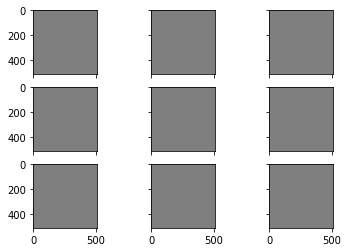

Iteration 2 of 1000 - Sun Feb 26 14:28:43 2023
Finishing ... - Sun Feb 26 14:28:47 2023
1/1 [==============================] - 0s 424ms/step
Training discriminator ... - Sun Feb 26 14:28:48 2023
Training generator ... - Sun Feb 26 14:28:53 2023
1/1 [==============================] - 1s 616ms/step
Epoch time 2 - Sun Feb 26 14:28:57 2023
Iteration 3 of 1000 - Sun Feb 26 14:28:57 2023
Finishing ... - Sun Feb 26 14:29:01 2023
1/1 [==============================] - 0s 454ms/step
Training discriminator ... - Sun Feb 26 14:29:02 2023
Training generator ... - Sun Feb 26 14:29:07 2023
1/1 [==============================] - 0s 435ms/step
Epoch time 3 - Sun Feb 26 14:29:11 2023
4 [D loss: 1.055491, acc.:76.56%] [G loss: 0.000000]
1/1 [==============================] - 0s 142ms/step


<Figure size 216x216 with 0 Axes>

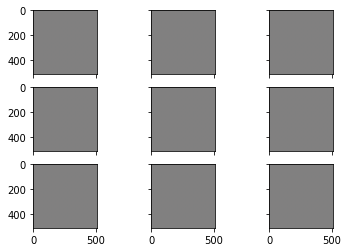

Iteration 4 of 1000 - Sun Feb 26 14:29:12 2023
Finishing ... - Sun Feb 26 14:29:17 2023
1/1 [==============================] - 0s 431ms/step
Training discriminator ... - Sun Feb 26 14:29:17 2023
Training generator ... - Sun Feb 26 14:29:22 2023
1/1 [==============================] - 0s 432ms/step
Epoch time 4 - Sun Feb 26 14:29:26 2023
Iteration 5 of 1000 - Sun Feb 26 14:29:26 2023
Finishing ... - Sun Feb 26 14:29:30 2023
1/1 [==============================] - 0s 401ms/step
Training discriminator ... - Sun Feb 26 14:29:31 2023
Training generator ... - Sun Feb 26 14:29:35 2023
1/1 [==============================] - 0s 404ms/step
Epoch time 5 - Sun Feb 26 14:29:38 2023
6 [D loss: 0.089605, acc.:100.00%] [G loss: 0.000000]
1/1 [==============================] - 0s 127ms/step


<Figure size 216x216 with 0 Axes>

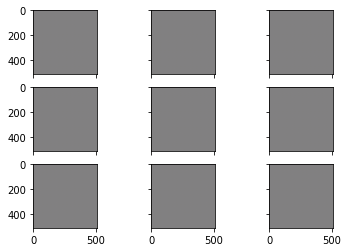

Iteration 6 of 1000 - Sun Feb 26 14:29:40 2023
Finishing ... - Sun Feb 26 14:29:44 2023
1/1 [==============================] - 0s 390ms/step
Training discriminator ... - Sun Feb 26 14:29:44 2023
Training generator ... - Sun Feb 26 14:29:49 2023
1/1 [==============================] - 0s 405ms/step
Epoch time 6 - Sun Feb 26 14:29:52 2023
Iteration 7 of 1000 - Sun Feb 26 14:29:52 2023
Finishing ... - Sun Feb 26 14:29:56 2023
1/1 [==============================] - 0s 402ms/step
Training discriminator ... - Sun Feb 26 14:29:57 2023
Training generator ... - Sun Feb 26 14:30:01 2023
1/1 [==============================] - 0s 411ms/step
Epoch time 7 - Sun Feb 26 14:30:04 2023
8 [D loss: 0.001797, acc.:100.00%] [G loss: 0.000000]
1/1 [==============================] - 0s 130ms/step


<Figure size 216x216 with 0 Axes>

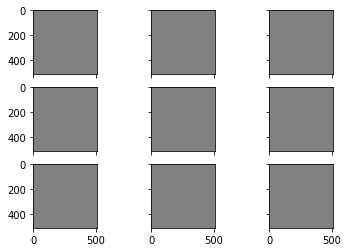

Iteration 8 of 1000 - Sun Feb 26 14:30:06 2023


ValueError: Could not load "" 
Reason: "image file is truncated"
Please see documentation at: http://pillow.readthedocs.io/en/latest/installation.html#external-libraries

In [103]:
train_gan(iterations, batch_size, sample_interval)